In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os, glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
DATA_ROOT = "/content/drive/My Drive/processed_pop909/fs_10"

FS = 4                # frame per second
STEPS_PER_BAR = 16
CTX_BARS = 2           # can see how many pre bars
BATCH_SIZE = 16
EPOCHS = 10

In [7]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 70.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.1 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.11-py3-none-any.whl size=5595886 sha256=758620f776af8614c2a2972da52f49e90862b3a4a591b15b9c2e8726191a9794
  Stored in directory: /root/.cache/pip/wheels/f4/ad/93/a7042fe12668827574927ade9deec7f29aad2a1001b1501882
Successfully built pretty_midi


In [8]:
import os
import numpy as np
import pretty_midi

# ============================================================
# load MIDI
# ============================================================
def load_pop909_midi(path):
    pm = pretty_midi.PrettyMIDI(path)

    melody = []
    bridge = []
    piano = []

    for inst in pm.instruments:
        name = inst.name.lower() if inst.name else ""

        if "melody" in name:
            melody.extend(inst.notes)
        elif "bridge" in name:
            bridge.extend(inst.notes)
        elif "piano" in name:
            piano.extend(inst.notes)
        else:
            piano.extend(inst.notes)

    melody.sort(key=lambda n: n.start)
    bridge.sort(key=lambda n: n.start)
    piano.sort(key=lambda n: n.start)

    return melody, bridge, piano, pm


# ============================================================
# notes → pianoroll
# ============================================================
def notes_to_pianoroll(notes, pm, fs=10):
    """
    fs=10
    fs=20
    """
    end_time = pm.get_end_time()
    T = int(end_time * fs) + 1

    roll = np.zeros((T, 128), dtype=np.float32)

    for n in notes:
        start = int(n.start * fs)
        end = int(n.end * fs)
        if end <= start:
            end = start + 1  # 避免 0 长度
        roll[start:end, n.pitch] = 1.0

    return roll


# ============================================================
# process POP909
# ============================================================
def process_pop909_dataset(input_root, output_root, fs_list=[2, 4, 6]):
    """
    input_root
    output_root
    fs_list
    """

    song_ids = sorted([d for d in os.listdir(input_root) if d.isdigit()])

    print(f"Found {len(song_ids)} songs in POP909.\n")

    for fs in fs_list:
        out_dir_fs = os.path.join(output_root, f"fs_{fs}")
        os.makedirs(out_dir_fs, exist_ok=True)

        print("="*60)
        print(f"Processing fs={fs} (1 frame = {1/fs:.3f} sec)")
        print("="*60)

        for sid in song_ids:
            song_folder = os.path.join(input_root, sid)
            midi_path = os.path.join(song_folder, f"{sid}.mid")

            if not os.path.exists(midi_path):
                print(f"[Warning] Missing MIDI file: {midi_path}")
                continue

            try:
                melody, bridge, piano, pm = load_pop909_midi(midi_path)

                mel_roll = notes_to_pianoroll(melody, pm, fs=fs)
                bri_roll = notes_to_pianoroll(bridge, pm, fs=fs)
                pai_roll = notes_to_pianoroll(piano, pm, fs=fs)

                out_dir_song = os.path.join(out_dir_fs, sid)
                os.makedirs(out_dir_song, exist_ok=True)

                np.save(os.path.join(out_dir_song, "melody.npy"), mel_roll)
                np.save(os.path.join(out_dir_song, "bridge.npy"), bri_roll)
                np.save(os.path.join(out_dir_song, "piano.npy"), pai_roll)

                print(f"[OK] {sid} completed.")

            except Exception as e:
                print(f"[ERROR] {sid}: {e}")

        print(f"\nFinished fs={fs}.\n")

    print("\n🎉 All fs datasets processed successfully!")


In [14]:
INPUT_DIR = "/content/drive/My Drive/POP909-Dataset-master/POP909"
OUTPUT_DIR = "/content/drive/My Drive/processed_pop909/"

process_pop909_dataset(INPUT_DIR, OUTPUT_DIR)

Found 909 songs in POP909.

Processing fs=2 (1 frame = 0.500 sec)
[OK] 001 completed.
[OK] 002 completed.
[OK] 003 completed.
[OK] 004 completed.
[OK] 005 completed.
[OK] 006 completed.
[OK] 007 completed.
[OK] 008 completed.
[OK] 009 completed.
[OK] 010 completed.
[OK] 011 completed.
[OK] 012 completed.
[OK] 013 completed.
[OK] 014 completed.
[OK] 015 completed.
[OK] 016 completed.
[OK] 017 completed.
[OK] 018 completed.
[OK] 019 completed.
[OK] 020 completed.
[OK] 021 completed.
[OK] 022 completed.
[OK] 023 completed.
[OK] 024 completed.
[OK] 025 completed.
[OK] 026 completed.
[OK] 027 completed.
[OK] 028 completed.
[OK] 029 completed.
[OK] 030 completed.
[OK] 031 completed.
[OK] 032 completed.
[OK] 033 completed.
[OK] 034 completed.
[OK] 035 completed.
[OK] 036 completed.
[OK] 037 completed.
[OK] 038 completed.
[OK] 039 completed.
[OK] 040 completed.
[OK] 041 completed.
[OK] 042 completed.
[OK] 043 completed.
[OK] 044 completed.
[OK] 045 completed.
[OK] 046 completed.
[OK] 047 compl

In [9]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import glob

class Pop909BarDataset(Dataset):
    def __init__(self, root_dir, split="train",
                 steps_per_bar=16, ctx_bars=8,
                 train_ratio=0.8, val_ratio=0.1):

        self.root_dir = root_dir
        self.steps_per_bar = steps_per_bar
        self.ctx_bars = ctx_bars

        all_songs = sorted(glob.glob(os.path.join(root_dir, "*")))
        all_songs = [p for p in all_songs if os.path.isdir(p)]
        assert len(all_songs) > 0, "No song folders found!"

        N = len(all_songs)
        n_train = int(N * train_ratio)
        n_val = int(N * val_ratio)

        if split == "train":
            self.song_dirs = all_songs[:n_train]
        elif split == "val":
            self.song_dirs = all_songs[n_train:n_train+n_val]
        else:
            self.song_dirs = all_songs[n_train+n_val:]

        print(f"{split} set has {len(self.song_dirs)} songs")

        self.mel_bars_list = []
        self.piano_bars_list = []
        self.index = []

        for s_idx, folder in enumerate(self.song_dirs):
            mel = np.load(os.path.join(folder, "melody.npy")).astype(np.float32)
            piano = np.load(os.path.join(folder, "piano.npy")).astype(np.float32)

            assert mel.shape == piano.shape
            T = mel.shape[0]

            n_bars = T // steps_per_bar
            if n_bars <= 1:
                continue

            mel = mel[:n_bars * steps_per_bar]
            piano = piano[:n_bars * steps_per_bar]

            mel_bars = mel.reshape(n_bars, steps_per_bar, 128)
            piano_bars = piano.reshape(n_bars, steps_per_bar, 128)

            self.mel_bars_list.append(mel_bars)
            self.piano_bars_list.append(piano_bars)

            for b in range(1, n_bars):
                self.index.append((s_idx, b))

        print(f"{split} total bar samples = {len(self.index)}")


    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        s_idx, b = self.index[idx]
        mel_bars = self.mel_bars_list[s_idx]
        piano_bars = self.piano_bars_list[s_idx]

        ctx = self.ctx_bars
        steps = self.steps_per_bar

        mel_ctx = np.zeros((ctx, steps, 128), dtype=np.float32)
        start_m = max(0, b - ctx + 1)
        mel_ctx[-(b - start_m + 1):] = mel_bars[start_m:b+1]

        piano_ctx = np.zeros((ctx, steps, 128), dtype=np.float32)
        start_p = max(0, b - ctx)
        if b - 1 >= start_p:
            piano_ctx[-(b - start_p):] = piano_bars[start_p:b]

        mel_bar = mel_bars[b]
        piano_bar = piano_bars[b]

        return (
            torch.from_numpy(mel_ctx.reshape(ctx*steps,128)),
            torch.from_numpy(piano_ctx.reshape(ctx*steps,128)),
            torch.from_numpy(mel_bar),
            torch.from_numpy(piano_bar),
        )





In [15]:
DATA_ROOT = "/content/drive/My Drive/processed_pop909/fs_2"

train_dataset = Pop909BarDataset(
    root_dir=DATA_ROOT,
    split="train",
    steps_per_bar=16,
    ctx_bars=2
)

val_dataset = Pop909BarDataset(
    root_dir=DATA_ROOT,
    split="val",
    steps_per_bar=16,
    ctx_bars=2
)

test_dataset = Pop909BarDataset(
    root_dir=DATA_ROOT,
    split="test",
    steps_per_bar=16,
    ctx_bars=2
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


train set has 727 songs
train total bar samples = 21704
val set has 90 songs
val total bar samples = 2626
test set has 92 songs
test total bar samples = 2710


## Explore models

In [16]:
class BarLSTMModel(nn.Module):
    """
    Encoder:
      input: concat(mel_ctx, piano_ctx)  -> [B, L_ctx, 256]
      output: (h, c) as Decoder's state

    Decoder:
      step input: [mel_t, prev_piano_t] -> 256
      output: current piano_t (logits, 128)
    """
    def __init__(self, hidden_dim=256, num_layers=2, steps_per_bar=16):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.steps_per_bar = steps_per_bar

        self.encoder = nn.LSTM(
            input_size=256,   # mel_ctx(128) + piano_ctx(128)
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
        )

        self.decoder = nn.LSTM(
            input_size=256,   # mel_t + prev_piano_t
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
        )

        self.fc = nn.Linear(hidden_dim, 128)

    def forward(self, mel_ctx, piano_ctx, mel_bar, piano_bar=None, teacher_forcing=True):
        """
        mel_ctx:   [B, L_ctx, 128]
        piano_ctx: [B, L_ctx, 128]
        mel_bar:   [B, steps, 128]
        piano_bar: [B, steps, 128]
        """
        B, L_ctx, _ = mel_ctx.shape
        steps = mel_bar.shape[1]

        # ----- Encoder -----
        enc_in = torch.cat([mel_ctx, piano_ctx], dim=-1)  # [B, L_ctx, 256]
        _, (h, c) = self.encoder(enc_in)                  # h,c: [num_layers, B, H]

        # ----- Decoder  -----
        outputs = []
        prev_p = torch.zeros(B, 128, device=mel_ctx.device)

        for t in range(steps):
            dec_in_t = torch.cat([mel_bar[:, t, :], prev_p], dim=-1).unsqueeze(1)  # [B,1,256]
            out, (h, c) = self.decoder(dec_in_t, (h, c))
            logit_t = self.fc(out[:, 0, :])                    # [B,128]
            outputs.append(logit_t)

            if teacher_forcing and (piano_bar is not None):
                prev_p = piano_bar[:, t, :]
            else:
                prev_p = torch.sigmoid(logit_t)

        logits = torch.stack(outputs, dim=1)  # [B, steps, 128]
        return logits


In [17]:
def smooth_labels(labels, eps=0.05):
    return labels * (1 - eps) + eps * 0.5

pos_weight = torch.tensor([10.0], device=device)  # tackle sparse data
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    for mel_ctx, piano_ctx, mel_bar, piano_bar in loader:
        mel_ctx   = mel_ctx.to(device).float()
        piano_ctx = piano_ctx.to(device).float()
        mel_bar   = mel_bar.to(device).float()
        piano_bar = piano_bar.to(device).float()

        piano_bar_s = smooth_labels(piano_bar)

        logits = model(mel_ctx, piano_ctx, mel_bar, piano_bar_s, teacher_forcing=True)
        loss = criterion(logits, piano_bar_s)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def validate(model, loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for mel_ctx, piano_ctx, mel_bar, piano_bar in loader:
            mel_ctx   = mel_ctx.to(device).float()
            piano_ctx = piano_ctx.to(device).float()
            mel_bar   = mel_bar.to(device).float()
            piano_bar = piano_bar.to(device).float()

            piano_bar_s = smooth_labels(piano_bar)
            logits = model(mel_ctx, piano_ctx, mel_bar, piano_bar_s, teacher_forcing=True)
            loss = criterion(logits, piano_bar_s)
            total_loss += loss.item()
    return total_loss / len(loader)


In [18]:
model = BarLSTMModel(hidden_dim=256, num_layers=2, steps_per_bar=STEPS_PER_BAR).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss = validate(model, val_loader)
    print(f"Epoch {epoch}/{EPOCHS}  |  Train={train_loss:.4f}  Val={val_loss:.4f}")

torch.save(model.state_dict(), "bar_lstm_accomp.pt")


Epoch 1/10  |  Train=0.7563  Val=0.7123
Epoch 2/10  |  Train=0.7166  Val=0.7050
Epoch 3/10  |  Train=0.7098  Val=0.7016
Epoch 4/10  |  Train=0.7055  Val=0.7000
Epoch 5/10  |  Train=0.7020  Val=0.6993
Epoch 6/10  |  Train=0.6989  Val=0.6991
Epoch 7/10  |  Train=0.6959  Val=0.6985
Epoch 8/10  |  Train=0.6930  Val=0.6991
Epoch 9/10  |  Train=0.6903  Val=0.7000
Epoch 10/10  |  Train=0.6876  Val=0.7007


In [17]:
def predict_bar(model, mel_ctx, piano_ctx, mel_bar,
                prob_thresh=0.5, max_notes_per_step=5):
    model.eval()
    with torch.no_grad():
        mel_ctx_t   = mel_ctx.unsqueeze(0).to(device).float()
        piano_ctx_t = piano_ctx.unsqueeze(0).to(device).float()
        mel_bar_t   = mel_bar.unsqueeze(0).to(device).float()

        logits = model(mel_ctx_t, piano_ctx_t, mel_bar_t,
                       piano_bar=None, teacher_forcing=False)
        prob = torch.sigmoid(logits)[0]              # [steps, 128]

        # filter by threshold first
        pred = (prob >= prob_thresh).float()

        # limit max_notes_per_step for every time step
        if max_notes_per_step is not None:
            topv, topi = prob.topk(max_notes_per_step, dim=-1)
            mask = torch.zeros_like(prob)
            mask.scatter_(1, topi, 1.0)
            pred = pred * mask

    return pred.cpu().numpy()



def plot_bar(gt_bar, pred_bar, title="Bar prediction"):
    """
    gt_bar, pred_bar: [steps,128]
    """
    steps = gt_bar.shape[0]
    t_gt, p_gt = np.where(gt_bar > 0.5)
    t_pr, p_pr = np.where(pred_bar > 0.5)

    plt.figure(figsize=(8, 4))
    plt.scatter(t_gt, p_gt, s=20, c="blue", alpha=0.7, label="GT")
    plt.scatter(t_pr, p_pr, s=20, c="red", alpha=0.7, label="Pred")
    plt.gca().invert_yaxis()
    plt.xlabel("Time step (within bar)")
    plt.ylabel("Pitch")
    plt.title(title)
    plt.legend()
    plt.show()


# get a sample
mel_ctx, piano_ctx, mel_bar, piano_bar = next(iter(test_loader))
mel_ctx   = mel_ctx[0]   # [L_ctx,128]
piano_ctx = piano_ctx[0]
mel_bar   = mel_bar[0]
piano_bar = piano_bar[0]

pred_bar = predict_bar(model, mel_ctx, piano_ctx, mel_bar, prob_thresh=0.7, max_notes_per_step=5)
plot_bar(piano_bar.numpy(), pred_bar, title="Test sample: one bar GT vs Pred")


TypeError: BarLSTMModel.forward() got an unexpected keyword argument 'piano_bar'

### Expolre2
Previous model tends to predict high probability. so we try some updates

In [34]:
pos_weight = torch.tensor([1.5]).to(device)
bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def compute_loss(logits, target, lambda_sparse=1e-4):
    """
    logits: (B, steps, 128)
    target: (B, steps, 128)
    """
    bce = bce_loss(logits, target)


    prob = torch.sigmoid(logits)
    sparse = prob.mean()

    loss = bce + lambda_sparse * sparse
    return loss



In [35]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    epochs=10,
    lambda_sparse=1e-4,
    save_path="checkpoints"
):
    os.makedirs(save_path, exist_ok=True)

    pos_weight = torch.tensor([10.0], device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def smooth_labels(labels, eps=0.05):
        return labels * (1 - eps) + eps * 0.5

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0

        for mel_ctx, piano_ctx, mel_bar, piano_bar in train_loader:
            mel_ctx   = mel_ctx.to(device).float()
            piano_ctx = piano_ctx.to(device).float()
            mel_bar   = mel_bar.to(device).float()
            piano_bar = piano_bar.to(device).float()

            # label smoothing
            piano_bar_s = smooth_labels(piano_bar)

            # forward with teacher forcing
            logits = model(
                mel_ctx,
                piano_ctx,
                mel_bar,
                piano_bar_s,
                teacher_forcing=True
            )

            # main loss
            bce_loss = criterion(logits, piano_bar_s)

            # sparsity regularization
            sparse_reg = logits.mean()

            loss = bce_loss + lambda_sparse * sparse_reg

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # ========== VALIDATION ==========
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for mel_ctx, piano_ctx, mel_bar, piano_bar in val_loader:
                mel_ctx   = mel_ctx.to(device).float()
                piano_ctx = piano_ctx.to(device).float()
                mel_bar   = mel_bar.to(device).float()
                piano_bar = piano_bar.to(device).float()

                piano_bar_s = smooth_labels(piano_bar)

                logits = model(
                    mel_ctx,
                    piano_ctx,
                    mel_bar,
                    piano_bar_s,
                    teacher_forcing=True
                )

                bce_loss = criterion(logits, piano_bar_s)
                sparse_reg = logits.mean()

                loss = bce_loss + lambda_sparse * sparse_reg
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f"Epoch {epoch}/{epochs} | Train={train_loss:.4f} | Val={val_loss:.4f}")

        # save each epoch
        torch.save(model.state_dict(), f"{save_path}/epoch_{epoch}.pt")

    print("Training finished!")


In [36]:
model = BarLSTMModel(hidden_dim=256, num_layers=2, steps_per_bar=STEPS_PER_BAR).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    epochs=10,
    lambda_sparse=1e-4,
    save_path="checkpoints"
)


Epoch 1/10 | Train=0.7547 | Val=0.7126
Epoch 2/10 | Train=0.7167 | Val=0.7046
Epoch 3/10 | Train=0.7100 | Val=0.7019
Epoch 4/10 | Train=0.7057 | Val=0.7002
Epoch 5/10 | Train=0.7022 | Val=0.6995
Epoch 6/10 | Train=0.6991 | Val=0.6986
Epoch 7/10 | Train=0.6960 | Val=0.6990
Epoch 8/10 | Train=0.6932 | Val=0.6991
Epoch 9/10 | Train=0.6904 | Val=0.6996
Epoch 10/10 | Train=0.6878 | Val=0.7003
Training finished!


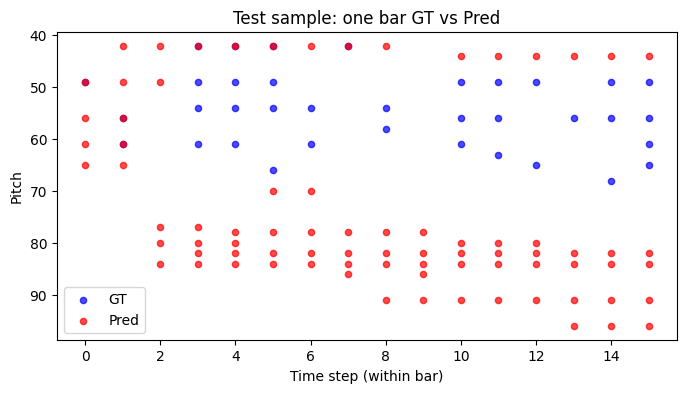

In [38]:
pred_bar = predict_bar(model, mel_ctx, piano_ctx, mel_bar, prob_thresh=0.7, max_notes_per_step=5)
plot_bar(piano_bar.numpy(), pred_bar, title="Test sample: one bar GT vs Pred")

In [10]:
import os
import numpy as np
from torch.utils.data import Dataset
import torch
import glob

class Pop909BarDataset(Dataset):
    def __init__(self, root_dir, split="train",
                 steps_per_bar=16, ctx_bars=8,
                 train_ratio=0.8, val_ratio=0.1):

        self.root_dir = root_dir
        self.steps_per_bar = steps_per_bar
        self.ctx_bars = ctx_bars

        all_songs = sorted(glob.glob(os.path.join(root_dir, "*")))
        all_songs = [p for p in all_songs if os.path.isdir(p)]
        assert len(all_songs) > 0, "No song folders found!"

        N = len(all_songs)
        n_train = int(N * train_ratio)
        n_val = int(N * val_ratio)

        if split == "train":
            self.song_dirs = all_songs[:n_train]
        elif split == "val":
            self.song_dirs = all_songs[n_train:n_train+n_val]
        else:
            self.song_dirs = all_songs[n_train+n_val:]

        print(f"{split} set has {len(self.song_dirs)} songs")

        self.mel_bars_list = []
        self.piano_bars_list = []
        self.index = []

        for s_idx, folder in enumerate(self.song_dirs):

            mel = np.load(os.path.join(folder, "melody.npy")).astype(np.float32)
            piano = np.load(os.path.join(folder, "piano.npy")).astype(np.float32)

            assert mel.shape == piano.shape
            T = mel.shape[0]

            n_bars = T // steps_per_bar
            if n_bars <= 1:
                continue

            mel = mel[:n_bars * steps_per_bar]
            piano = piano[:n_bars * steps_per_bar]

            mel_bars = mel.reshape(n_bars, steps_per_bar, 128)
            piano_bars = piano.reshape(n_bars, steps_per_bar, 128)

            self.mel_bars_list.append(mel_bars)
            self.piano_bars_list.append(piano_bars)

            for b in range(1, n_bars):
                self.index.append((s_idx, b))

        print(f"{split} total bar samples = {len(self.index)}")

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):

        s_idx, b = self.index[idx]
        mel_bars = self.mel_bars_list[s_idx]
        piano_bars = self.piano_bars_list[s_idx]

        ctx = self.ctx_bars
        steps = self.steps_per_bar

        # ------------ Melody Context ------------
        mel_ctx = np.zeros((ctx, steps, 128), dtype=np.float32)
        start_m = max(0, b - ctx + 1)
        mel_ctx[-(b - start_m + 1):] = mel_bars[start_m:b+1]

        # ------------ Piano Context ------------
        piano_ctx = np.zeros((ctx, steps, 128), dtype=np.float32)
        start_p = max(0, b - ctx)
        if b - 1 >= start_p:
            piano_ctx[-(b - start_p):] = piano_bars[start_p:b]

        #  melody/piano
        mel_cur = mel_bars[b]         # shape: (steps,128)
        piano_cur = piano_bars[b]     # shape: (steps,128)

        return (
            torch.from_numpy(mel_ctx),        # (ctx,steps,128)
            torch.from_numpy(piano_ctx),      # (ctx,steps,128)
            torch.from_numpy(mel_cur),        # (steps,128)
            torch.from_numpy(piano_cur),      # (steps,128)
        )


In [12]:
DATA_ROOT = "/content/drive/My Drive/processed_pop909/fs_4"

train_dataset = Pop909BarDataset(
    root_dir=DATA_ROOT,
    split="train",
    steps_per_bar=16,
    ctx_bars=8
)

val_dataset = Pop909BarDataset(
    root_dir=DATA_ROOT,
    split="val",
    steps_per_bar=16,
    ctx_bars=8
)

test_dataset = Pop909BarDataset(
    root_dir=DATA_ROOT,
    split="test",
    steps_per_bar=16,
    ctx_bars=8
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


train set has 727 songs
train total bar samples = 44468
val set has 90 songs
val total bar samples = 5382
test set has 92 songs
test total bar samples = 5557


In [13]:
import torch
import torch.nn as nn

class BarLSTMModel(nn.Module):
    def __init__(self, hidden_dim=256, num_layers=2, steps_per_bar=16):
        super().__init__()
        self.steps = steps_per_bar

        self.input_dim = 128 + 128 + 128

        self.lstm = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False
        )

        self.output_layer = nn.Linear(hidden_dim, 128)

    def forward(self, mel_ctx, piano_ctx, mel_cur):
        """
        mel_ctx  : (B, ctx, steps, 128)
        piano_ctx: (B, ctx, steps, 128)
        mel_cur  : (B, steps, 128)
        """

        B, ctx, S, _ = mel_ctx.shape

        # flatten context: (B, ctx*steps, 128)
        mel_ctx_f = mel_ctx.reshape(B, ctx*S, 128)
        piano_ctx_f = piano_ctx.reshape(B, ctx*S, 128)

        # expand mel_cur shape → repeat along ctx dimension？
        mel_cur_rep = mel_cur.unsqueeze(1).repeat(1, ctx, 1, 1).reshape(B, ctx*S, 128)

        # context
        lstm_in = torch.cat([mel_ctx_f, piano_ctx_f, mel_cur_rep], dim=-1)   # (B, ctx*S, 384)

        # LSTM
        out, _ = self.lstm(lstm_in)  # (B, ctx*S, hidden)

        last_h = out[:, -1, :]  # (B, hidden)

        pred = self.output_layer(last_h).unsqueeze(1).repeat(1, S, 1)
        return pred


In [14]:
pos_weight = torch.tensor([1.5], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for mel_ctx, piano_ctx, mel_cur, piano_cur in loader:

        mel_ctx   = mel_ctx.to(device).float()
        piano_ctx = piano_ctx.to(device).float()
        mel_cur   = mel_cur.to(device).float()
        piano_cur = piano_cur.to(device).float()

        optimizer.zero_grad()

        pred = model(mel_ctx, piano_ctx, mel_cur)

        loss = criterion(pred, piano_cur)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def validate(model, loader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for mel_ctx, piano_ctx, mel_cur, piano_cur in loader:

            mel_ctx   = mel_ctx.to(device).float()
            piano_ctx = piano_ctx.to(device).float()
            mel_cur   = mel_cur.to(device).float()
            piano_cur = piano_cur.to(device).float()

            pred = model(mel_ctx, piano_ctx, mel_cur)
            loss = criterion(pred, piano_cur)

            total_loss += loss.item()

    return total_loss / len(loader)


In [15]:
model = BarLSTMModel(
    hidden_dim=512,
    num_layers=2,
    steps_per_bar=STEPS_PER_BAR
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(20):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss   = validate(model, val_loader, criterion)
    print(f"Epoch {epoch+1} | Train={train_loss:.4f} | Val={val_loss:.4f}")

torch.save(model.state_dict(), "bar_lstm_harmony.pt")


Epoch 1 | Train=0.1059 | Val=0.1016
Epoch 2 | Train=0.1037 | Val=0.1023
Epoch 3 | Train=0.1038 | Val=0.1018
Epoch 4 | Train=0.1038 | Val=0.1016
Epoch 5 | Train=0.0932 | Val=0.0860
Epoch 6 | Train=0.0860 | Val=0.0829
Epoch 7 | Train=0.0825 | Val=0.0802
Epoch 8 | Train=0.0796 | Val=0.0784
Epoch 9 | Train=0.0779 | Val=0.0785
Epoch 10 | Train=0.0765 | Val=0.0772
Epoch 11 | Train=0.0753 | Val=0.0771
Epoch 12 | Train=0.0741 | Val=0.0770
Epoch 13 | Train=0.0729 | Val=0.0772
Epoch 14 | Train=0.0717 | Val=0.0773
Epoch 15 | Train=0.0704 | Val=0.0778
Epoch 16 | Train=0.0692 | Val=0.0783
Epoch 17 | Train=0.0680 | Val=0.0789
Epoch 18 | Train=0.0669 | Val=0.0795
Epoch 19 | Train=0.0658 | Val=0.0804
Epoch 20 | Train=0.0648 | Val=0.0806


In [18]:
def predict_bar(model, mel_ctx, piano_ctx, mel_cur,
                prob_thresh=0.5, max_notes_per_step=5):
    model.eval()
    with torch.no_grad():
        mel_ctx_t   = mel_ctx.unsqueeze(0).to(device).float()
        piano_ctx_t = piano_ctx.unsqueeze(0).to(device).float()
        mel_cur_t   = mel_cur.unsqueeze(0).to(device).float()

        logits = model(mel_ctx_t, piano_ctx_t, mel_cur_t)   # new forward!
        prob = torch.sigmoid(logits)[0]  # [steps,128]

        pred = (prob >= prob_thresh).float()

        if max_notes_per_step is not None:
            topv, topi = prob.topk(max_notes_per_step, dim=-1)
            mask = torch.zeros_like(prob)
            mask.scatter_(1, topi, 1.0)
            pred = pred * mask

    return pred.cpu().numpy()


In [19]:
def plot_bar(gt_bar, pred_bar, title="Bar prediction"):
    """
    gt_bar, pred_bar: [steps,128]
    """
    steps = gt_bar.shape[0]
    t_gt, p_gt = np.where(gt_bar > 0.5)
    t_pr, p_pr = np.where(pred_bar > 0.5)

    plt.figure(figsize=(8, 4))
    plt.scatter(t_gt, p_gt, s=20, c="blue", alpha=0.7, label="GT")
    plt.scatter(t_pr, p_pr, s=20, c="red", alpha=0.7, label="Pred")
    plt.gca().invert_yaxis()
    plt.xlabel("Time step (within bar)")
    plt.ylabel("Pitch")
    plt.title(title)
    plt.legend()
    plt.show()

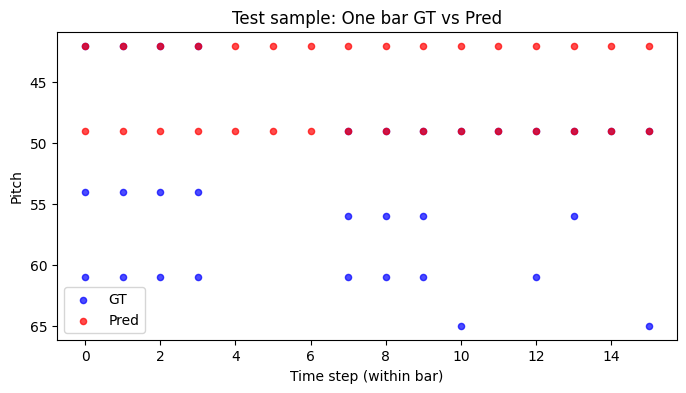

In [27]:
mel_ctx, piano_ctx, mel_bar, piano_bar = next(iter(test_loader))

mel_ctx_single   = mel_ctx[0]     # [ctx_bars,16,128]
piano_ctx_single = piano_ctx[0]   # [ctx_bars,16,128]
mel_bar_single   = mel_bar[0]     # [16,128]
gt_bar_single    = piano_bar[0]   # [16,128]

pred_bar = predict_bar(
    model,
    mel_ctx_single,
    piano_ctx_single,
    mel_bar_single,
    prob_thresh=0.5,
    max_notes_per_step=5
)

plot_bar(gt_bar_single.numpy(), pred_bar, "Test sample: One bar GT vs Pred")


In [28]:
DATA_ROOT = "/content/drive/My Drive/processed_pop909/fs_2"

train_dataset = Pop909BarDataset(
    root_dir=DATA_ROOT,
    split="train",
    steps_per_bar=16,
    ctx_bars=4
)

val_dataset = Pop909BarDataset(
    root_dir=DATA_ROOT,
    split="val",
    steps_per_bar=16,
    ctx_bars=4
)

test_dataset = Pop909BarDataset(
    root_dir=DATA_ROOT,
    split="test",
    steps_per_bar=16,
    ctx_bars=4
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

train set has 727 songs
train total bar samples = 21704
val set has 90 songs
val total bar samples = 2626
test set has 92 songs
test total bar samples = 2710


In [39]:
import torch.nn as nn
import torch

class BarLSTMModel(nn.Module):

    def __init__(self, hidden_dim=256, num_layers=2, steps_per_bar=16):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.steps_per_bar = steps_per_bar

        # Encoder
        self.encoder = nn.LSTM(
            input_size=256,   # mel_ctx(128) + piano_ctx(128)
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
        )

        # Decoder
        self.decoder = nn.LSTM(
            input_size=256,   # mel_t + prev_piano_t
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
        )

        self.fc = nn.Linear(hidden_dim, 128)

    def forward(self, mel_ctx, piano_ctx, mel_bar,
                piano_bar=None, teacher_forcing=True):

        B = mel_ctx.shape[0]
        ctx_bars = mel_ctx.shape[1]
        steps_per_bar = mel_ctx.shape[2]

        # flatten L_ctx = ctx_bars * steps_per_bar
        mel_ctx = mel_ctx.reshape(B, ctx_bars * steps_per_bar, 128)
        piano_ctx = piano_ctx.reshape(B, ctx_bars * steps_per_bar, 128)

        steps = mel_bar.shape[1]

        # Encoder
        enc_in = torch.cat([mel_ctx, piano_ctx], dim=-1)
        _, (h, c) = self.encoder(enc_in)

        # Decoder
        outputs = []
        prev_p = torch.zeros(B, 128, device=mel_ctx.device)

        for t in range(steps):
            dec_in_t = torch.cat([mel_bar[:, t, :], prev_p], dim=-1).unsqueeze(1)
            out, (h, c) = self.decoder(dec_in_t, (h, c))
            logit_t = self.fc(out[:, 0, :])
            outputs.append(logit_t)

            if teacher_forcing and piano_bar is not None:
                prev_p = piano_bar[:, t, :]
            else:
                prev_p = torch.sigmoid(logit_t)

        logits = torch.stack(outputs, dim=1)
        return logits


In [35]:
pos_weight = torch.tensor([3.0], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def smooth_labels(labels, eps=0.05):
    # slight label smoothing
    return labels * (1 - eps) + eps * 0.5

def compute_loss(logits, target, lambda_sparse=1e-4):
    """
    logits: (B, steps, 128)
    target: (B, steps, 128)
    """
    target_s = smooth_labels(target)
    bce = criterion(logits, target_s)

    prob = torch.sigmoid(logits)
    sparse = prob.mean()   # more pintch，more penalty

    return bce + lambda_sparse * sparse


In [37]:
import os

def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    epochs=20,
    lambda_sparse=1e-4,
    save_path="checkpoints_fs2_ctx4"
):
    os.makedirs(save_path, exist_ok=True)

    for epoch in range(1, epochs + 1):
        # --------- Train ---------
        model.train()
        train_loss = 0.0

        for mel_ctx, piano_ctx, mel_bar, piano_bar in train_loader:
            mel_ctx   = mel_ctx.to(device).float()
            piano_ctx = piano_ctx.to(device).float()
            mel_bar   = mel_bar.to(device).float()
            piano_bar = piano_bar.to(device).float()

            logits = model(
                mel_ctx,
                piano_ctx,
                mel_bar,
                piano_bar,
                teacher_forcing=True
            )

            loss = compute_loss(logits, piano_bar, lambda_sparse=lambda_sparse)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # --------- Validation ---------
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for mel_ctx, piano_ctx, mel_bar, piano_bar in val_loader:
                mel_ctx   = mel_ctx.to(device).float()
                piano_ctx = piano_ctx.to(device).float()
                mel_bar   = mel_bar.to(device).float()
                piano_bar = piano_bar.to(device).float()

                logits = model(
                    mel_ctx,
                    piano_ctx,
                    mel_bar,
                    piano_bar,
                    teacher_forcing=True
                )

                loss = compute_loss(logits, piano_bar, lambda_sparse=lambda_sparse)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f"Epoch {epoch}/{epochs} | Train={train_loss:.4f} | Val={val_loss:.4f}")

        torch.save(model.state_dict(), f"{save_path}/epoch_{epoch}.pt")

    print("Training finished!")


In [40]:
model = BarLSTMModel(
    hidden_dim=256,
    num_layers=2,
    steps_per_bar=STEPS_PER_BAR
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    epochs=20,
    lambda_sparse=1e-4,
    save_path="checkpoints_fs2_ctx4"
)


Epoch 1/20 | Train=0.3703 | Val=0.3394
Epoch 2/20 | Train=0.3404 | Val=0.3317
Epoch 3/20 | Train=0.3361 | Val=0.3293
Epoch 4/20 | Train=0.3337 | Val=0.3278
Epoch 5/20 | Train=0.3320 | Val=0.3269
Epoch 6/20 | Train=0.3305 | Val=0.3258
Epoch 7/20 | Train=0.3293 | Val=0.3250
Epoch 8/20 | Train=0.3281 | Val=0.3247
Epoch 9/20 | Train=0.3270 | Val=0.3242
Epoch 10/20 | Train=0.3264 | Val=0.3239
Epoch 11/20 | Train=0.3250 | Val=0.3238
Epoch 12/20 | Train=0.3240 | Val=0.3234
Epoch 13/20 | Train=0.3230 | Val=0.3236
Epoch 14/20 | Train=0.3220 | Val=0.3236
Epoch 15/20 | Train=0.3211 | Val=0.3237
Epoch 16/20 | Train=0.3201 | Val=0.3239
Epoch 17/20 | Train=0.3192 | Val=0.3243
Epoch 18/20 | Train=0.3183 | Val=0.3246
Epoch 19/20 | Train=0.3174 | Val=0.3250
Epoch 20/20 | Train=0.3164 | Val=0.3258
Training finished!


In [41]:
import numpy as np
import matplotlib.pyplot as plt

def predict_bar(model, mel_ctx, piano_ctx, mel_bar,
                prob_thresh=0.7, max_notes_per_step=5):
    """
    mel_ctx:   [L_ctx,128]
    piano_ctx: [L_ctx,128]
    mel_bar:   [steps,128]
    """
    model.eval()
    with torch.no_grad():
        mel_ctx_t   = mel_ctx.unsqueeze(0).to(device).float()
        piano_ctx_t = piano_ctx.unsqueeze(0).to(device).float()
        mel_bar_t   = mel_bar.unsqueeze(0).to(device).float()

        logits = model(
            mel_ctx_t,
            piano_ctx_t,
            mel_bar_t,
            piano_bar=None,
            teacher_forcing=False
        )  # [1,steps,128]

        prob = torch.sigmoid(logits)[0]  # [steps,128]

        pred = (prob >= prob_thresh).float()

        if max_notes_per_step is not None:
            topv, topi = prob.topk(max_notes_per_step, dim=-1)
            mask = torch.zeros_like(prob)
            mask.scatter_(1, topi, 1.0)
            pred = pred * mask

    return pred.cpu().numpy()


In [42]:
def plot_bar(gt_bar, pred_bar, title="Bar prediction"):
    """
    gt_bar, pred_bar: [steps,128]
    """
    t_gt, p_gt = np.where(gt_bar > 0.5)
    t_pr, p_pr = np.where(pred_bar > 0.5)

    plt.figure(figsize=(8, 4))
    plt.scatter(t_gt, p_gt, s=20, c="blue", alpha=0.7, label="GT")
    plt.scatter(t_pr, p_pr, s=20, c="red", alpha=0.7, label="Pred")
    plt.gca().invert_yaxis()
    plt.xlabel("Time step (within bar)")
    plt.ylabel("Pitch")
    plt.title(title)
    plt.legend()
    plt.show()


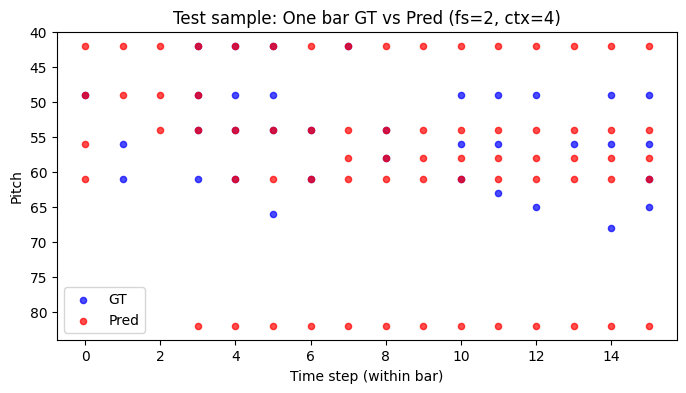

In [47]:
mel_ctx_b, piano_ctx_b, mel_bar_b, piano_bar_b = next(iter(test_loader))

mel_ctx   = mel_ctx_b[0]   # [L_ctx,128]
piano_ctx = piano_ctx_b[0] # [L_ctx,128]
mel_bar   = mel_bar_b[0]   # [steps,128]
piano_bar = piano_bar_b[0] # [steps,128]

pred_bar = predict_bar(
    model,
    mel_ctx,
    piano_ctx,
    mel_bar,
    prob_thresh=0.5,
    max_notes_per_step=5
)

plot_bar(piano_bar.numpy(), pred_bar,
         title="Test sample: One bar GT vs Pred (fs=2, ctx=4)")


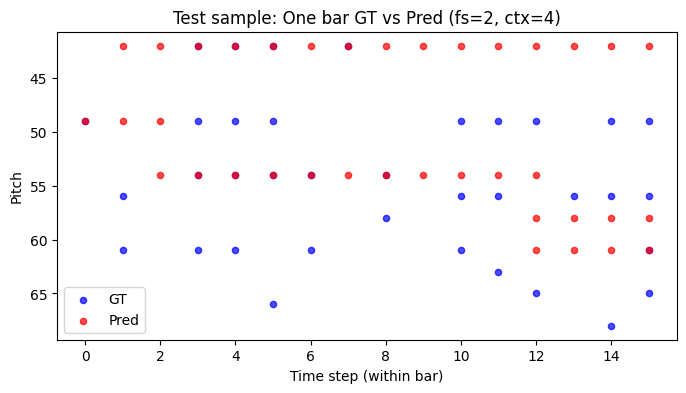

In [48]:
pred_bar = predict_bar(
    model,
    mel_ctx,
    piano_ctx,
    mel_bar,
    prob_thresh=0.7,
    max_notes_per_step=5
)

plot_bar(piano_bar.numpy(), pred_bar,
         title="Test sample: One bar GT vs Pred (fs=2, ctx=4)")

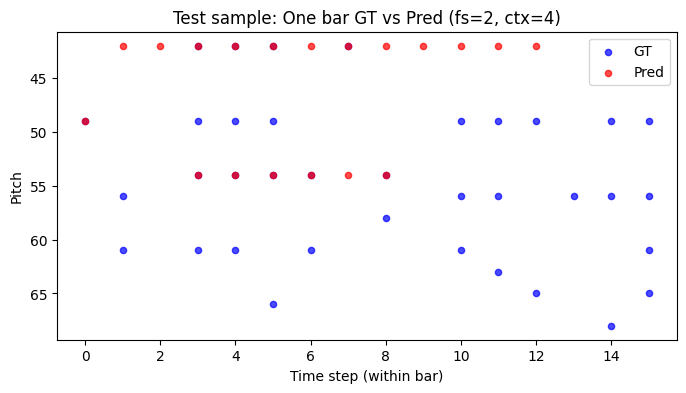

In [49]:
pred_bar = predict_bar(
    model,
    mel_ctx,
    piano_ctx,
    mel_bar,
    prob_thresh=0.8,
    max_notes_per_step=5
)

plot_bar(piano_bar.numpy(), pred_bar,
         title="Test sample: One bar GT vs Pred (fs=2, ctx=4)")

In [53]:
def predict_song(model, mel_bars, piano_bars,
                 ctx_bars=4,
                 prob_thresh=0.7,
                 max_notes_per_step=5):

    num_bars, steps, _ = mel_bars.shape
    pred_bars = np.zeros((num_bars, steps, 128), dtype=np.float32)

    pred_bars[0] = np.zeros((steps, 128))

    for b in range(1, num_bars):

        mel_ctx = np.zeros((ctx_bars, steps, 128), dtype=np.float32)
        piano_ctx = np.zeros((ctx_bars, steps, 128), dtype=np.float32)

        left = max(0, b - ctx_bars)
        used = b - left

        mel_ctx[-used:] = mel_bars[left:b]

        piano_ctx[-used:] = piano_bars[left:b]

        mel_cur = mel_bars[b]

        mel_ctx_t   = torch.tensor(mel_ctx, dtype=torch.float32, device=device).unsqueeze(0)
        piano_ctx_t = torch.tensor(piano_ctx, dtype=torch.float32, device=device).unsqueeze(0)
        mel_cur_t   = torch.tensor(mel_cur, dtype=torch.float32, device=device).unsqueeze(0)

        with torch.no_grad():
            logits = model(mel_ctx_t, piano_ctx_t, mel_cur_t, teacher_forcing=False)
            prob = torch.sigmoid(logits)[0].cpu().numpy()

            pred = (prob >= prob_thresh).astype(np.float32)

            if max_notes_per_step is not None:
                topv = np.partition(prob, -max_notes_per_step, axis=-1)[:, -max_notes_per_step]
                mask = prob >= topv[:, None]
                pred = pred * mask

        pred_bars[b] = pred

    return pred_bars


In [51]:
song_idx = 0

mel_bars  = test_dataset.mel_bars_list[song_idx]
piano_bars = test_dataset.piano_bars_list[song_idx]

print("mel_bars:", mel_bars.shape)
print("piano_bars:", piano_bars.shape)

mel_bars: (22, 16, 128)
piano_bars: (22, 16, 128)


In [68]:
pred_bars = predict_song(model, mel_bars, piano_bars,
                         ctx_bars=4, prob_thresh=0.7,max_notes_per_step=9)

def flatten_bars(bars):   # bars: [num_bars, steps, 128]
    num_bars, steps, _ = bars.shape
    return bars.reshape(num_bars * steps, 128)

gt_flat  = flatten_bars(piano_bars)     # [T,128]
pred_flat = flatten_bars(pred_bars)     # [T,128]



In [55]:
def plot_full_song(gt_flat, pred_flat, title="Full-song GT vs Prediction"):
    """
    gt_flat, pred_flat: [T,128]
    """
    T = gt_flat.shape[0]

    t_gt, p_gt = np.where(gt_flat > 0.5)
    t_pr, p_pr = np.where(pred_flat > 0.5)

    plt.figure(figsize=(15, 6))
    plt.scatter(t_gt, p_gt, s=8, c="blue", alpha=0.5, label="GT")
    plt.scatter(t_pr, p_pr, s=8, c="red", alpha=0.5, label="Pred")

    plt.xlabel("Time step (frames for full song)")
    plt.ylabel("Pitch")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()


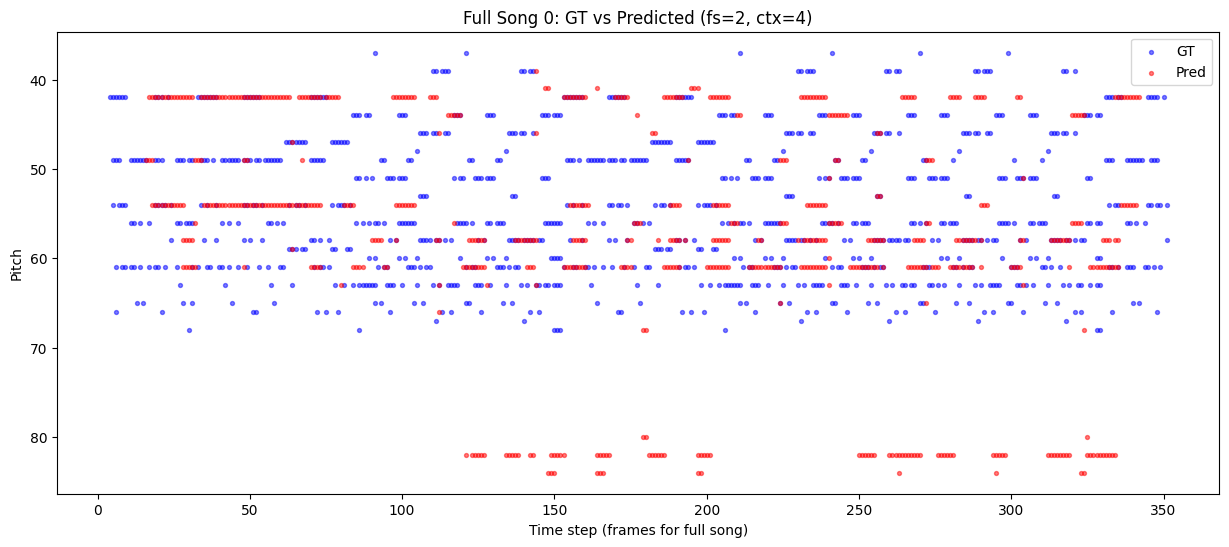

In [69]:
plot_full_song(gt_flat, pred_flat,
               title=f"Full Song {song_idx}: GT vs Predicted (fs=2, ctx=4)")



In [70]:
def predict_testset(model, dataset, prob_thresh=0.7,max_notes_per_step=5):
    results = []

    for i, song_dir in enumerate(dataset.song_dirs):
        mel = np.load(os.path.join(song_dir, "melody.npy")).astype(np.float32)
        piano = np.load(os.path.join(song_dir, "piano.npy")).astype(np.float32)

        # reshape to bars
        T = mel.shape[0]
        steps = dataset.steps_per_bar
        num_bars = T // steps

        mel_bars = mel[:num_bars * steps].reshape(num_bars, steps, 128)
        piano_bars = piano[:num_bars * steps].reshape(num_bars, steps, 128)

        pred_bars = predict_song(
            model, mel_bars, piano_bars,
            ctx_bars=dataset.ctx_bars,
            prob_thresh=prob_thresh,
            max_notes_per_step=5
        )

        results.append((song_dir, mel_bars, piano_bars, pred_bars))
        print(f"Predicted {i+1}/{len(dataset.song_dirs)} songs")

    return results


In [59]:
def bars_to_midi(mel_bars, bridge_bars, pred_piano_bars, steps_per_bar=16, fs=2, save_path="song.mid"):
    """
    mel_bars, bridge_bars, pred_piano_bars: [num_bars, steps, 128]
    """
    pm = pretty_midi.PrettyMIDI()

    inst_mel = pretty_midi.Instrument(program=0)
    inst_bridge = pretty_midi.Instrument(program=40)
    inst_pred = pretty_midi.Instrument(program=1)

    num_bars = pred_piano_bars.shape[0]
    dt = 1.0 / fs   # frame duration

    def add_notes(inst, bars):
        for b in range(num_bars):
            for t in range(steps_per_bar):
                pitches = np.where(bars[b, t] > 0.5)[0]
                for p in pitches:
                    start = (b * steps_per_bar + t) * dt
                    end = start + dt
                    inst.notes.append(pretty_midi.Note(80, int(p), start, end))

    add_notes(inst_mel, mel_bars)
    add_notes(inst_bridge, bridge_bars)
    add_notes(inst_pred, pred_piano_bars)

    pm.instruments.append(inst_mel)
    pm.instruments.append(inst_bridge)
    pm.instruments.append(inst_pred)
    pm.write(save_path)


In [71]:
results = predict_testset(model, test_dataset, prob_thresh=0.7,max_notes_per_step=10)

for i in range(5):
    song_dir, mel_bars, bridge_bars, pred_bars = results[i]
    out = f"test_song_{i+1}.mid"
    bars_to_midi(mel_bars, bridge_bars, pred_bars, steps_per_bar=16, fs=2, save_path=out)
    print("Saved:", out)


Predicted 1/92 songs
Predicted 2/92 songs
Predicted 3/92 songs
Predicted 4/92 songs
Predicted 5/92 songs
Predicted 6/92 songs
Predicted 7/92 songs
Predicted 8/92 songs
Predicted 9/92 songs
Predicted 10/92 songs
Predicted 11/92 songs
Predicted 12/92 songs
Predicted 13/92 songs
Predicted 14/92 songs
Predicted 15/92 songs
Predicted 16/92 songs
Predicted 17/92 songs
Predicted 18/92 songs
Predicted 19/92 songs
Predicted 20/92 songs
Predicted 21/92 songs
Predicted 22/92 songs
Predicted 23/92 songs
Predicted 24/92 songs
Predicted 25/92 songs
Predicted 26/92 songs
Predicted 27/92 songs
Predicted 28/92 songs
Predicted 29/92 songs
Predicted 30/92 songs
Predicted 31/92 songs
Predicted 32/92 songs
Predicted 33/92 songs
Predicted 34/92 songs
Predicted 35/92 songs
Predicted 36/92 songs
Predicted 37/92 songs
Predicted 38/92 songs
Predicted 39/92 songs
Predicted 40/92 songs
Predicted 41/92 songs
Predicted 42/92 songs
Predicted 43/92 songs
Predicted 44/92 songs
Predicted 45/92 songs
Predicted 46/92 son

In [72]:
import numpy as np
import os

os.makedirs("/content/drive/My Drive/predictions", exist_ok=True)

def save_prediction_npy(song_idx, pred_bars):
    out_path = f"predictions/pred_song{song_idx}.npy"
    np.save(out_path, pred_bars)
    print(f"Saved: {out_path}")


In [90]:
def align_tracks_with_integer_tail(mel, bridge, pred, steps_per_bar=16):
    """
    mel, bridge: 原始 melody / bridge track (flat pianoroll)
    pred: 模型预测出的 pianoroll
    steps_per_bar: 每小节的时间步数（你现在 fs=2 → 一般 steps_per_bar=16）

    返回 mel_a, bridge_a, pred_a — 已对齐并保证尾部为整数小节
    """

    Lm = len(mel)
    Lb = len(bridge)
    Lp = len(pred)

    base_len = max(Lm, Lb)
    keep_len = base_len + steps_per_bar

    pred_trim = pred[:keep_len]

    final_len = max(Lm, Lb, len(pred_trim))

    def pad_track(t, target):
        if len(t) == target:
            return t
        return np.concatenate([t, np.zeros((target - len(t), t.shape[1]))], axis=0)
    print('------')
    print(Lm,Lb,Lp)
    return pad_track(mel, final_len), pad_track(bridge, final_len), pad_track(pred_trim, final_len)


In [79]:
import random
def humanize_events(events, vel_jitter=15, dur_jitter=0.1, merge_prob=0.1):

    if not events:
        return []

    new = []
    prev_pitch = None
    prev_event = None

    for start, dur, pitch, vel in events:

        # velocity jitter
        vel = int(max(1, min(120, vel + random.randint(-vel_jitter, vel_jitter))))

        # duration jitter
        dur = max(1, int(dur * (1 + random.uniform(-dur_jitter, dur_jitter))))

        # merge consecutive same-pitch notes
        if prev_pitch == pitch and random.random() < merge_prob:
            prev_event[1] += dur
            continue

        event = [start, dur, pitch, vel]
        new.append(event)

        prev_pitch = pitch
        prev_event = event

    return new


In [80]:
from mido import Message, MidiFile, MidiTrack, bpm2tempo

def pianoroll_to_events(roll, velocity=80):
    T = roll.shape[0]
    events = []

    for pitch in range(128):
        active = False
        start = 0
        dur = 0

        for t in range(T):
            if roll[t, pitch] > 0.7:
                if not active:
                    active = True
                    start = t
                    dur = 1
                else:
                    dur += 1
            else:
                if active:
                    events.append((start, dur, pitch, velocity))
                    active = False

        if active:
            events.append((start, dur, pitch, velocity))

    return events



In [81]:
from mido import Message, MidiFile, MidiTrack, bpm2tempo
from mido import Message, MidiFile, MidiTrack, MetaMessage, bpm2tempo

def write_three_track_midi_named(mel, bri, pred, out_path, fs=16, bpm=120, humanize=True):
    mid = MidiFile()
    ticks_per_beat = mid.ticks_per_beat
    ticks_per_step = ticks_per_beat // fs

    # （mel / bridge / pred）
    def add_track(roll, name, base_vel=90, human=False):
        track = MidiTrack()
        mid.tracks.append(track)

        track.append(MetaMessage("track_name", name=name, time=0))

        events = pianoroll_to_events(roll, velocity=base_vel)
        if human:
            events = humanize_events(events)

        events.sort(key=lambda x: x[0])

        last_tick = 0
        for start, dur, pitch, vel in events:
            start_tick = start * ticks_per_step
            dur_tick = dur * ticks_per_step

            delta = max(0, start_tick - last_tick)

            track.append(Message("note_on", note=pitch, velocity=vel, time=delta))
            track.append(Message("note_off", note=pitch, velocity=0, time=dur_tick))

            last_tick = start_tick + dur_tick

    add_track(mel, "Melody", 90, human=False)
    add_track(bri, "Bridge", 85, human=False)
    add_track(pred, "Piano_Pred", 70, human=True)

    mid.save(out_path)
    print(f"Saved MIDI → {out_path}")



In [91]:
os.makedirs("/content/drive/My Drive/predictions/midis", exist_ok=True)

STEPS_PER_BAR = 2

def flatten(bars):
    nb, steps, _ = bars.shape
    return bars.reshape(nb * steps, 128)

for song_idx in range(5):

    # === Load song ===
    mel_bars  = test_dataset.mel_bars_list[song_idx]
    piano_bars = test_dataset.piano_bars_list[song_idx]
    bridge     = np.load(os.path.join(test_dataset.song_dirs[song_idx], "bridge.npy"))

    # === Predict piano ===
    pred_bars = predict_song(
        model,
        mel_bars,
        piano_bars,
        ctx_bars=4,
        prob_thresh=0.7,
        max_notes_per_step=10
    )

    # === Flatten ===
    mel_flat   = flatten(mel_bars)
    br_flat    = bridge
    pred_flat  = flatten(pred_bars)

    # === align melody, bridge 与 predicted piano ===
    mel_aligned, br_aligned, pred_aligned = align_tracks_with_integer_tail(
        mel_flat, br_flat, pred_flat, steps_per_bar=STEPS_PER_BAR
    )

    # === Save clean MIDI ===
    out_clean = f"/content/drive/My Drive/predictions/midis/song{song_idx}_pred.mid"
    write_three_track_midi_named(
        mel_aligned, br_aligned, pred_aligned,
        out_clean, fs=STEPS_PER_BAR, bpm=120, humanize=False
    )

    # === Save humanized MIDI ===
    out_human = f"/content/drive/My Drive/predictions/midis/song{song_idx}_pred_human.mid"
    write_three_track_midi_named(
        mel_aligned, br_aligned, pred_aligned,
        out_human, fs=STEPS_PER_BAR, bpm=120, humanize=True
    )


------
352 363 352
Saved MIDI → /content/drive/My Drive/predictions/midis/song0_pred.mid
Saved MIDI → /content/drive/My Drive/predictions/midis/song0_pred_human.mid
------
448 453 448
Saved MIDI → /content/drive/My Drive/predictions/midis/song1_pred.mid
Saved MIDI → /content/drive/My Drive/predictions/midis/song1_pred_human.mid
------
336 339 336
Saved MIDI → /content/drive/My Drive/predictions/midis/song2_pred.mid
Saved MIDI → /content/drive/My Drive/predictions/midis/song2_pred_human.mid
------
544 553 544
Saved MIDI → /content/drive/My Drive/predictions/midis/song3_pred.mid
Saved MIDI → /content/drive/My Drive/predictions/midis/song3_pred_human.mid
------
480 485 480
Saved MIDI → /content/drive/My Drive/predictions/midis/song4_pred.mid
Saved MIDI → /content/drive/My Drive/predictions/midis/song4_pred_human.mid


## Light Transformer

In [93]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =======================
# Positional Encoding
# =======================

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1024):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()
                             * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: [B, L, d_model]
        """
        L = x.size(1)
        return x + self.pe[:, :L, :]

Using device: cuda


In [111]:
class BarTransformer(nn.Module):
    def __init__(self, steps_per_bar=16,
                 d_model=256, nhead=4,
                 num_encoder_layers=3, num_decoder_layers=3,
                 dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.steps_per_bar = steps_per_bar
        self.d_model = d_model

        # mel_ctx(128) + piano_ctx(128) = 256
        self.enc_in_proj = nn.Linear(256, d_model)
        self.dec_in_proj = nn.Linear(128, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=2048)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.out_proj = nn.Linear(d_model, 128)

    # -------------------------
    #   修复后的 encode()
    #   不再假设 mel_ctx 是 (B, L_ctx, 128)
    #   而是 (B, L_ctx_flat,128)
    # -------------------------
    def encode(self, mel_ctx, piano_ctx, mel_bar):
        # mel_ctx, piano_ctx may be 4D: [B, ctx_bars, steps, 128]
        if mel_ctx.dim() == 4:
            B, C, S, P = mel_ctx.shape
            mel_ctx = mel_ctx.reshape(B, C*S, P)    # → [B, L_ctx_flat, 128]

        if piano_ctx.dim() == 4:
            B, C, S, P = piano_ctx.shape
            piano_ctx = piano_ctx.reshape(B, C*S, P)

        # mel_bar is already [B, steps, 128], OK
        zero_piano = torch.zeros_like(mel_bar)

        # context input
        ctx = torch.cat([mel_ctx, piano_ctx], dim=-1)  # [B, L_ctx_flat, 256]
        ctx = self.enc_in_proj(ctx)

        # current bar
        cur = torch.cat([mel_bar, zero_piano], dim=-1)  # [B, steps, 256]
        cur = self.enc_in_proj(cur)

        # concat context + current bar
        enc_in = torch.cat([ctx, cur], dim=1)  # [B, L_ctx_flat + steps, d_model]
        enc_in = self.pos_enc(enc_in)

        return self.encoder(enc_in)


    def forward(self, mel_ctx, piano_ctx, mel_bar, piano_bar):
        memory = self.encode(mel_ctx, piano_ctx, mel_bar)

        B, steps, _ = piano_bar.shape

        tgt = self.dec_in_proj(piano_bar)
        tgt = self.pos_enc(tgt)

        tgt_mask = torch.triu(
            torch.ones(steps, steps, device=tgt.device) * float('-inf'), 1
        )

        out = self.decoder(tgt, memory, tgt_mask=tgt_mask)
        logits = self.out_proj(out)
        logits = logits * 3.0
        return logits

    def generate_bar(self, mel_ctx, piano_ctx, mel_bar,
                     prob_thresh=0.5, max_notes_per_step=8):

        self.eval()
        with torch.no_grad():
            memory = self.encode(mel_ctx, piano_ctx, mel_bar)

            B = mel_ctx.shape[0]
            steps = mel_bar.shape[1]
            generated = torch.zeros(B, steps, 128, device=mel_ctx.device)

            for t in range(steps):
                tgt = self.dec_in_proj(generated[:, :t+1])
                tgt = self.pos_enc(tgt)

                tgt_mask = torch.triu(
                    torch.ones(t+1, t+1, device=tgt.device) * float('-inf'), 1
                )

                out = self.decoder(tgt, memory, tgt_mask=tgt_mask)
                logits_t = self.out_proj(out[:, -1])

                prob_t = torch.sigmoid(logits_t)
                pred_t = (prob_t >= prob_thresh).float()

                if max_notes_per_step is not None:
                    topv, topi = prob_t.topk(max_notes_per_step, dim=-1)
                    mask = torch.zeros_like(prob_t)
                    mask.scatter_(1, topi, 1.0)
                    pred_t = pred_t * mask

                generated[:, t] = pred_t

            return generated[0].cpu().numpy()


In [95]:
# =======================
# DataLoader
# =======================

STEPS_PER_BAR = 16
CTX_BARS = 4
BATCH_SIZE = 32

DATA_ROOT = "/content/drive/My Drive/processed_pop909/fs_2"
train_dataset = Pop909BarDataset(
    root_dir=DATA_ROOT,
    split="train",
    steps_per_bar=STEPS_PER_BAR,
    ctx_bars=CTX_BARS
)
val_dataset = Pop909BarDataset(
    root_dir=DATA_ROOT,
    split="val",
    steps_per_bar=STEPS_PER_BAR,
    ctx_bars=CTX_BARS
)
test_dataset = Pop909BarDataset(
    root_dir=DATA_ROOT,
    split="test",
    steps_per_bar=STEPS_PER_BAR,
    ctx_bars=CTX_BARS
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, drop_last=False)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

train set has 727 songs
train total bar samples = 21704
val set has 90 songs
val total bar samples = 2626
test set has 92 songs
test total bar samples = 2710


In [125]:
# =======================
# Train
# =======================

pos_weight = torch.tensor([5.0], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def compute_loss(logits, target):
    # 主 BCE loss
    bce = criterion(logits, target)

    # 激活率（越接近 0 越说明模型在静音）
    prob = torch.sigmoid(logits)
    activation = prob.mean()

    # 我们希望模型每个 frame 至少激活一点点（例如 0.05）
    target_activation = 0.1
    act_penalty = (target_activation - activation).relu()

    # 加入惩罚项
    loss = bce + 0.1 * act_penalty
    return loss


def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0

    for mel_ctx, piano_ctx, mel_bar, piano_bar in loader:
        mel_ctx   = mel_ctx.to(device).float()
        piano_ctx = piano_ctx.to(device).float()
        mel_bar   = mel_bar.to(device).float()
        piano_bar = piano_bar.to(device).float()

        logits = model(mel_ctx, piano_ctx, mel_bar, piano_bar)
        loss = compute_loss(logits, piano_bar)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def validate(model, loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for mel_ctx, piano_ctx, mel_bar, piano_bar in loader:
            mel_ctx   = mel_ctx.to(device).float()
            piano_ctx = piano_ctx.to(device).float()
            mel_bar   = mel_bar.to(device).float()
            piano_bar = piano_bar.to(device).float()

            logits = model(mel_ctx, piano_ctx, mel_bar, piano_bar)
            loss = compute_loss(logits, piano_bar)
            total_loss += loss.item()
    return total_loss / len(loader)

In [126]:
model = BarTransformer(
    steps_per_bar=STEPS_PER_BAR,
    d_model=256,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=512,
    dropout=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

EPOCHS = 10

for ep in range(1, EPOCHS+1):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss   = validate(model, val_loader)
    print(f"Epoch {ep}/{EPOCHS} | Train={train_loss:.4f} | Val={val_loss:.4f}")

torch.save(model.state_dict(), "bar_transformer_pop909.pt")
print("Model saved.")


Epoch 1/10 | Train=0.0617 | Val=0.0090
Epoch 2/10 | Train=0.0094 | Val=0.0081
Epoch 3/10 | Train=0.0083 | Val=0.0078
Epoch 4/10 | Train=0.0080 | Val=0.0078
Epoch 5/10 | Train=0.0078 | Val=0.0077
Epoch 6/10 | Train=0.0077 | Val=0.0077
Epoch 7/10 | Train=0.0076 | Val=0.0076
Epoch 8/10 | Train=0.0076 | Val=0.0076
Epoch 9/10 | Train=0.0076 | Val=0.0076
Epoch 10/10 | Train=0.0076 | Val=0.0076
Model saved.


In [100]:
for mel_ctx, piano_ctx, mel_bar, piano_bar in train_loader:
    print("mel_ctx:", mel_ctx.shape)
    print("piano_ctx:", piano_ctx.shape)
    print("mel_bar:", mel_bar.shape)
    print("piano_bar:", piano_bar.shape)
    break

mel_ctx: torch.Size([32, 4, 16, 128])
piano_ctx: torch.Size([32, 4, 16, 128])
mel_bar: torch.Size([32, 16, 128])
piano_bar: torch.Size([32, 16, 128])


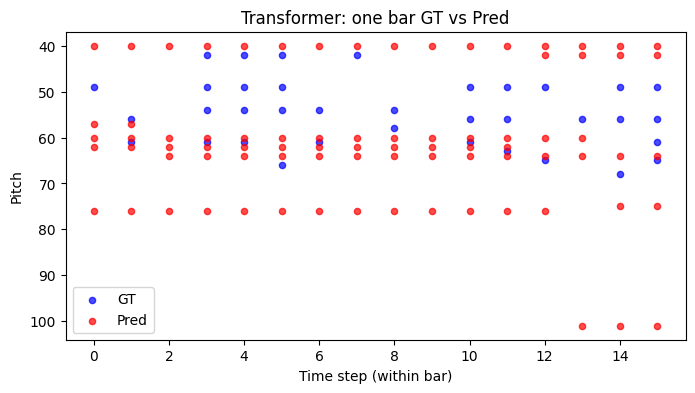

In [129]:
def plot_bar(gt_bar, pred_bar, title="Bar prediction"):
    """
    gt_bar, pred_bar: [steps,128]
    """
    t_gt, p_gt = np.where(gt_bar > 0.5)
    t_pr, p_pr = np.where(pred_bar > 0.5)

    plt.figure(figsize=(8, 4))
    plt.scatter(t_gt, p_gt, s=20, c="blue", alpha=0.7, label="GT")
    plt.scatter(t_pr, p_pr, s=20, c="red", alpha=0.7, label="Pred")
    plt.gca().invert_yaxis()
    plt.xlabel("Time step (within bar)")
    plt.ylabel("Pitch")
    plt.title(title)
    plt.legend()
    plt.show()

mel_ctx, piano_ctx, mel_bar, piano_bar = next(iter(test_loader))
mel_ctx   = mel_ctx.to(device).float()
piano_ctx = piano_ctx.to(device).float()
mel_bar   = mel_bar.to(device).float()
piano_bar = piano_bar.to(device).float()

with torch.no_grad():
    pred_bar = model.generate_bar(
        mel_ctx, piano_ctx, mel_bar,
        prob_thresh=0.00,
        max_notes_per_step=5
    )

gt_bar_np = piano_bar[0].cpu().numpy()
plot_bar(gt_bar_np, pred_bar, title="Transformer: one bar GT vs Pred")